In [17]:
import pandas as pd
import numpy as np
import nltk
import re
import time
from sklearn.utils import resample
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

In [3]:
df = pd.read_csv('../data/Reviews.csv')

In [4]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

df['Summary'].fillna("", inplace=True)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewSentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0


In [6]:
def preprocess(s):
    # Remove html tags
    s = re.sub('<\S+>', '', s)
    # Replace urls with token
    s = re.sub(r'http:\S+', 'url', s)
    s = re.sub(r'https:\S+', 'url', s)
    
    s = s.lower()
    # Remove any other special characters
    s = re.sub(r'[^a-z ]', ' ', s)
    
    words = s.split()
    result = []
    
    # Remove stop words and lemmatize the words
    for word in words:
        if word in stop_words:
            continue
        word = lemmatizer.lemmatize(word)
        result.append(word)
    return ' '.join(result)

df['PreprocessText'] = df['Summary'].apply(preprocess)


In [7]:
negative = df[df['ReviewSentiment']==0]
positive = df[df['ReviewSentiment']==1]
print('Number of negative samples:', len(negative))
print('Number of positive samples:', len(positive))

Number of negative samples: 124677
Number of positive samples: 443777


In [20]:
num_samples = 5000
positive_downsampled = resample(positive, replace=True, 
                                n_samples=num_samples,
                                random_state=1)
negative_downsampled = resample(negative, replace=True, 
                                n_samples=num_samples,
                                random_state=1)
print('Number of positive downsampled:', len(positive_downsampled))
print('Number of negative downsampled:', len(negative_downsampled))
downsampled = pd.concat([negative_downsampled, positive_downsampled])
print('Total Number of rows after downsampling:', len(downsampled))

Number of positive downsampled: 5000
Number of negative downsampled: 5000
Total Number of rows after downsampling: 10000


In [21]:
downsampled.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewSentiment,PreprocessText
445591,445592,B000DZFMG4,A5FGP8DJ0KNEV,"William L. Stokes ""BillS""",0,1,1,1235692800,Pam Cookies:,I will never buy Cookies OL again. What I got ...,0.0,pam cooky
350705,350706,B005HPOUYU,AQUWZQCBF1KGO,Richard Lewis,0,0,1,1349740800,Terrible ...,These are the worst tasting BBQ Vienna sausage...,0.0,terrible
22293,22294,B000MOQHCO,A1072LLI2DPQL6,Bruce MacKenzie,0,0,3,1245542400,Ho-hum,I received my order this chocolate quickly and...,0.0,ho hum
443215,443216,B000FW3RSU,A331T1MEPUCBYV,"Suzanna Davis ""suzanna""",0,1,3,1247443200,seem fattier than corn chips,I am gluten and dairy allergic so I am always ...,0.0,seem fattier corn chip
225104,225105,B001LNTY70,A3Q3EVDIIIRLLL,Shorty,0,4,3,1307577600,"Taste great, price not so great!!","The cans are teeny tiny, and for what they cha...",0.0,taste great price great


In [22]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_fv = tfidf.fit_transform(downsampled['PreprocessText'])

In [23]:
std_data = StandardScaler(with_mean = False).fit_transform(tfidf_fv)
std_data=std_data.todense()
print(type(std_data),std_data.shape)

<class 'numpy.matrix'> (10000, 966)


# tSNE

In [27]:
model = TSNE(n_components=2, perplexity=5, learning_rate=100, n_iter = 250, random_state=0, verbose=1)
tsne_fit = model.fit_transform(std_data)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.656s...
[t-SNE] Computed neighbors for 10000 samples in 160.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.259918
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704

NameError: name 'score' is not defined

In [47]:
# data_tsne = np.vstack((tsne_fit.T, downsampled['ReviewSentiment'])).T
'''tsneDf = pd.DataFrame(data=data_tsne, columns=['Comp1','Comp2','Score'])
sns.set()
sns.set(rc={"figure.figsize": (10, 8)})
sns.FacetGrid(tsneDf, hue="Score", height=9).map(plt.scatter, 'Comp1', 'Comp2').add_legend()
plt.title("TSNE - TFIDF")'''

'tsneDf = pd.DataFrame(data=data_tsne, columns=[\'Comp1\',\'Comp2\',\'Score\'])\nsns.set()\nsns.set(rc={"figure.figsize": (10, 8)})\nsns.FacetGrid(tsneDf, hue="Score", height=9).map(plt.scatter, \'Comp1\', \'Comp2\').add_legend()\nplt.title("TSNE - TFIDF")'

# PCA 

In [24]:
pca = PCA(n_components=2)
points = pca.fit_transform(std_data)

In [25]:
sns.set()
sns.set(rc={"figure.figsize": (10, 8)})
PALETTE = sns.color_palette('deep', n_colors=3)
CMAP = ListedColormap(PALETTE.as_hex())

def plot_2d(x, y, labels, title, xlabel="PCA1", ylabel="PCA2"):
    sns.set_style("darkgrid")
    
    plt.scatter(x, y,
        c=labels,
        cmap=CMAP,
        s=70)
    
    plt.title(title, fontsize=20, y=1.03)

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

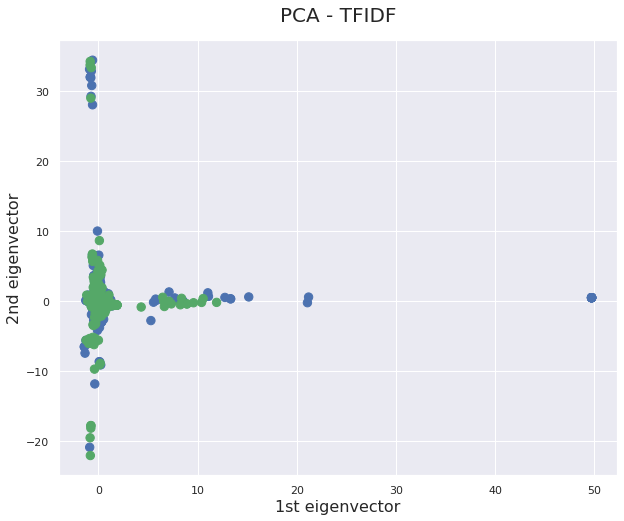

In [31]:
plot_2d(points[:, 0], points[:, 1], downsampled['ReviewSentiment'], 'PCA - TFIDF')

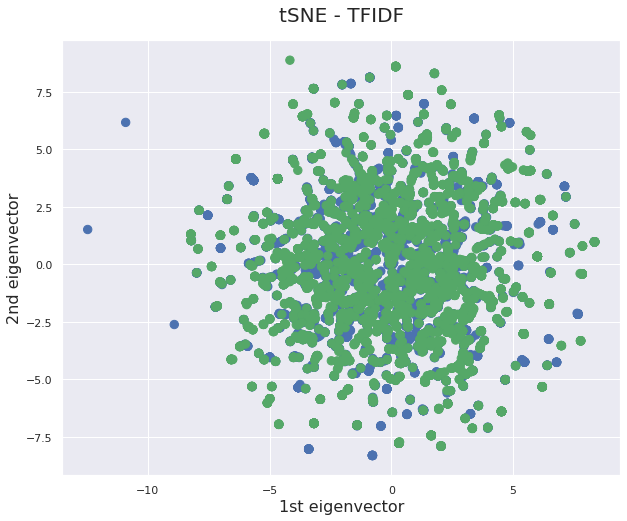

In [46]:
# TSNE
plot_2d(tsne_fit[:,0], tsne_fit[:,1], downsampled['ReviewSentiment'], 'tSNE - TFIDF')

# Glove Vectors

In [94]:
def remove_spl_chars(text):
    text = re.sub('[^a-z]', ' ', text)
    return text

def get_corpus(data):
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer() 
    words_count = dict()
    
    for text in tqdm(data['Summary']):        
        text = str(text).lower()
        text = remove_spl_chars(text)
        tokens = text.split()
        for token in tokens:
            if token in stop_words:
                continue
            token = lemmatizer.lemmatize(token)
            if token in words_count:
                words_count[token] = words_count[token] + 1
            else:
                words_count[token] = 1
    return words_count

In [98]:
neg_words_count = get_corpus(negative_downsampled)
pos_words_count = get_corpus(positive_downsampled)

100%|██████████| 5000/5000 [00:00<00:00, 60171.87it/s]


In [99]:
neg_words_count = sorted(neg_words_count.items(), key=lambda x: x[1], reverse=True)
#neg_words_count

In [100]:
pos_words_count = sorted(pos_words_count.items(), key=lambda x: x[1], reverse=True)
#pos_words_count

In [64]:
embeddings_index = {}
with open('glove/glove.6B.50d.txt', encoding="utf8") as f:
    line = f.readline()
    while line:
        values = line.split()
        word = values[0]
        try:
           coefs = np.asarray(values[1:], dtype='float32')
           embeddings_index[word] = coefs
        except ValueError:
           pass
        line = f.readline()

In [113]:
count = 0
vectors = []
labels = []
num_words = 2000
for word, n in pos_words_count:
    try:
        vectors.append(embeddings_index[word])
        labels.append(1)
        count +=1 
        if count == num_words:
            break
    except:
        pass

count = 0
for word, n in neg_words_count:
    try:
        vectors.append(embeddings_index[word])
        labels.append(0)
        count +=1 
        if count == num_words:
            break
    except:
        pass

In [114]:
pca = PCA(n_components=2)
points = pca.fit_transform(vectors)

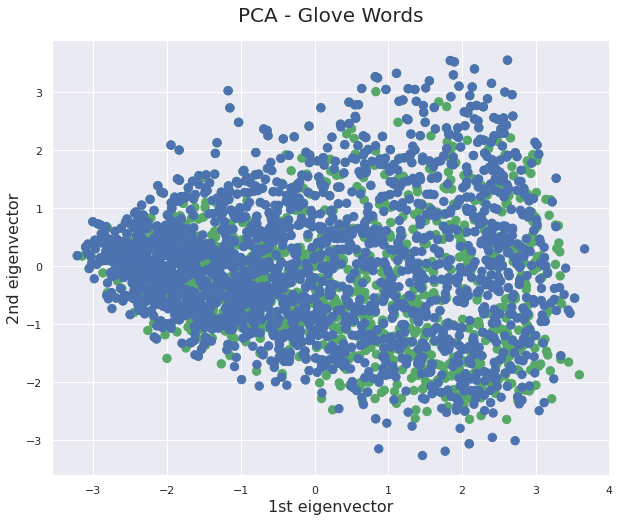

In [115]:
plot_2d(points[:, 0], points[:, 1], labels, 'PCA - Glove Words')